# Gaussian Imputation

In [7]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from scipy.stats import t, laplace, norm
import seaborn as sns
from sklearn.datasets import make_spd_matrix

try:
    from probml_utils import pyprobml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import pyprobml_utils as pml

from probml_utils import savefig, latexify, is_latexify_enabled
from probml_utils import gauss_utils as gauss

In [2]:
latexify(width_scale_factor=2, fig_height=3.0, font_size=14)

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
def plot_hinton_data(data, title, save_name="", graph_pos_ind=1, max_weight=7):
    """
    Draw a hinton plot

    Args:
    ----------
    data : JAX array
        Data for the hinton plot

    title : string
        Title for graph

    save_name : string, default=''
        Filename for the saved graph

    graph_pos_ind : int, default=1
        Graph position indicator, to
        distinguish between different
        plots

    max_weight : int, default=7
        Parameter to control area of
        hinton patches.

    Returns:
    ----------
    None
    """

    # Generate Hinton Plot
    plot = plt.figure(graph_pos_ind)
    pml.hinton_diagram(data, max_weight=max_weight, ax=plot.gca())

    # Update labels and title
    plt.title(title)
    plt.ylabel("Dimension of data")
    plt.xlabel("Sample Number")

    # Bring patches to front, above grid
    for patch in plot.axes[0].patches:
        patch.zorder = 2

    # Update the line width and alpha while saving the figure
    if is_latexify_enabled():
        plt.grid(linewidth=0.5, alpha=0.8)

    # Hide the y-axis and labels
    if not graph_pos_ind == 1:
        plt.ylabel("Placeholder", color="w")
        plot.axes[0].tick_params(axis="y", colors="w")

    # Save figure to files
    if len(save_name) > 0:
        savefig(save_name)

    plt.show()

In [4]:
def gen_imputer_data(data_dim=8, sample_size=10, threshold_missing=0.5):
    """
    Sample from a multivariate normal distribution generated using random
    mean and covariance. Use guassian imputer to update randomly
    removed values

    Args:
    ----------
    data_dim : int,deafult=8
        Dimension of data

    sample_size : int, default=10
        Number of samples

    threshold_missing : float, default=0.5
        Threshold to hide values

    Returns:
    ----------
    None
    """

    # Generate Mean for Multivariate gaussian
    mean = random.normal(random.PRNGKey(42), shape=(data_dim, 1))

    # Generate a random positive definite matrix i.e covariance matrix
    cov = make_spd_matrix(n_dim=data_dim)

    # Test if the matrix is positive definite
    if not gauss.is_pos_def(cov):
        print(f"The covariance matrix is not positive definite. \n {cov}")
        return None

    # Generate True data matrix
    x_true = gauss.gauss_sample(mean, cov, sample_size)

    # Randomly adding nan values to True data matrix to create observed data matrix
    missing_idx = random.normal(random.PRNGKey(53), shape=(sample_size, data_dim)) < threshold_missing
    x_observed = jnp.copy(x_true)
    x_observed = x_observed.at[missing_idx].set(jnp.nan)

    # Imputing missing/nan values to create imputed data matrix
    x_imputed = gauss.gauss_impute(mean, cov, x_observed)

    # For plotting, replace nan values with 0's
    x_observed0 = jnp.copy(x_true)
    x_observed0 = x_observed0.at[missing_idx].set(0)

    # Plot the data
    plot_hinton_data(
        x_observed0,
        "Observed data matrix",
        "gauss_impute_observed",
        graph_pos_ind=1,
    )
    plot_hinton_data(x_true, "True data matrix", "gauss_impute_truth", graph_pos_ind=2)
    plot_hinton_data(
        x_imputed,
        "Imputed data matrix",
        "gauss_impute_pred",
        graph_pos_ind=3,
    )

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


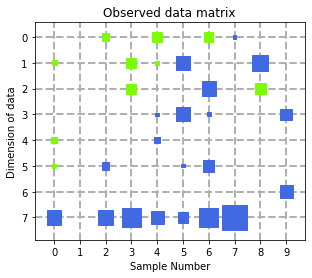

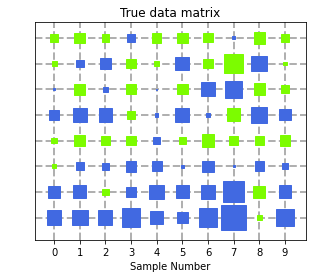

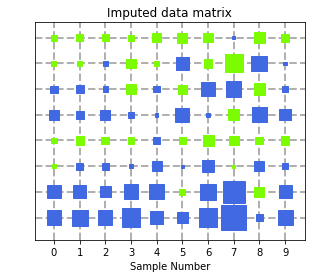

In [5]:
gen_imputer_data()

In [6]:
from ipywidgets import interact
import ipywidgets as widgets


@interact(
    data_dim=widgets.IntSlider(description="data_dim", min=5, max=15, value=10, continuous_update=False),
    sample_size=widgets.IntSlider(description="sample_size", min=5, max=15, value=10, continuous_update=False),
    threshold_missing=widgets.FloatSlider(
        description="threshold_missing",
        min=0,
        max=1,
        value=0.5,
        step=0.1,
        continuous_update=False,
    ),
)
def update(data_dim, sample_size, threshold_missing):
    gen_imputer_data(data_dim=data_dim, sample_size=sample_size, threshold_missing=threshold_missing)

interactive(children=(IntSlider(value=10, continuous_update=False, description='data_dim', max=15, min=5), Int…